In [1]:
import numpy as np # linear algebra
np.random.seed(666)
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from subprocess import check_output
import utils

Using Theano backend.


In [3]:
#Load data
train = pd.read_json("/home/ubuntu/statoil/data/train_half/train.json")
valid = pd.read_json("/home/ubuntu/statoil/data/train_half/valid.json")
test = pd.read_json("/home/ubuntu/statoil/data/train/test.json")
train.inc_angle = train.inc_angle.replace('na', 0)
train.inc_angle = train.inc_angle.astype(float).fillna(0.0)
valid.inc_angle = valid.inc_angle.replace('na', 0)
valid.inc_angle = valid.inc_angle.astype(float).fillna(0.0)
print("done!")

done!


In [4]:

# Train data
x_band1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
x_band2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])
X_train = np.concatenate([x_band1[:, :, :, np.newaxis]
                          , x_band2[:, :, :, np.newaxis]
                         , ((x_band1+x_band2)/2)[:, :, :, np.newaxis]], axis=-1)
X_angle_train = np.array(train.inc_angle)
y_train = np.array(train["is_iceberg"])

# Valid data
x_band1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in valid["band_1"]])
x_band2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in valid["band_2"]])
X_valid = np.concatenate([x_band1[:, :, :, np.newaxis]
                          , x_band2[:, :, :, np.newaxis]
                         , ((x_band1+x_band2)/2)[:, :, :, np.newaxis]], axis=-1)
X_angle_valid = np.array(valid.inc_angle)
y_valid = np.array(valid["is_iceberg"])

# Test data
x_band1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])
x_band2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_2"]])
X_test = np.concatenate([x_band1[:, :, :, np.newaxis]
                          , x_band2[:, :, :, np.newaxis]
                         , ((x_band1+x_band2)/2)[:, :, :, np.newaxis]], axis=-1)
X_angle_test = np.array(test.inc_angle)

In [5]:
from matplotlib import pyplot
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]
    
model = utils.keras_baselilne()
model.summary()

utils.py:103: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), activation="elu")`
  img_1 = Conv2D(16,3,3, activation=p_activation) (input_1)
utils.py:104: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), activation="elu")`
  img_1 = Conv2D(16,3,3, activation=p_activation) (img_1)
utils.py:107: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="elu")`
  img_1 = Conv2D(32, 3,3, activation=p_activation) (img_1)
utils.py:108: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="elu")`
  img_1 = Conv2D(32, 3,3, activation=p_activation) (img_1)
utils.py:111: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  img_1 = Conv2D(64,3,3, activation=p_activation) (img_1)
utils.py:112: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  img_1 = Conv2D(64,3,3, activatio

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
X_1 (InputLayer)                 (None, 75, 75, 3)     0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 73, 73, 16)    448         X_1[0][0]                        
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 71, 71, 16)    2320        conv2d_1[0][0]                   
____________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 35, 35, 16)    0           conv2d_2[0][0]                   
___________________________________________________________________________________________

In [91]:
batch_size=32
reload(utils)

#gen = ImageDataGenerator(vertical_flip = True)

#gen = ImageDataGenerator(zoom_range = 0.1)


#gen = ImageDataGenerator(horizontal_flip = True,
#                         vertical_flip = True,
#                         width_shift_range = 0.1,
#                         height_shift_range = 0.1,
#                         zoom_range = 0.1,
#                         rotation_range = 40)


# Finally create out generator
#gen_flow = utils.gen_flow_for_two_inputs(X_train, X_angle_train, y_train, gen)

#genX1 = gen.flow(X_train,y_train,  batch_size=32,seed=666)
gen_flow = utils.self_generator(X_train, X_angle_train, y_train, batch_size, method='black_box_gen',box_size=10)

In [108]:
file_path = "/home/ubuntu/statoil/weights/.model_black_box_gen.hdf5"
callbacks = get_callbacks(filepath=file_path, patience=30)

model = utils.keras_baselilne()
model.fit_generator(gen_flow, validation_data=([X_valid, X_angle_valid], y_valid),
                    steps_per_epoch=len(X_train) / 32, epochs=40, callbacks=callbacks)

Epoch 1/40
18/18 [==============================] - 76s - loss: 1.0463 - acc: 0.4878 - val_loss: 0.6430 - val_acc: 0.6050

In [95]:
reload(utils)
X_train_final, X_angle_train_final, y_train_final = utils.black_box(X_train,X_angle_train,y_train, number_syn=7, box_size=10)

In [96]:
file_path = "/home/ubuntu/statoil/weights/.model_black_box.hdf5"
callbacks = get_callbacks(filepath=file_path, patience=30)

reload(utils)
model = utils.keras_baselilne()
model.fit([X_train_final,X_angle_train_final], y_train_final, epochs=20
          , validation_data=([X_valid, X_angle_valid], y_valid)
         , batch_size=64
         , callbacks=callbacks)

Train on 4214 samples, validate on 200 samples
Epoch 1/20
4214/4214 [==============================] - 469s - loss: 0.9526 - acc: 0.5062 - val_loss: 0.9422 - val_acc: 0.5500

In [109]:
optimizer = Adam(lr=0.00001)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
model.load_weights(filepath=file_path)
model.fit([X_train,X_angle_train], y_train, epochs=20
          , validation_data=([X_valid, X_angle_valid], y_valid)
         , batch_size=32
         , callbacks=callbacks)

Train on 602 samples, validate on 200 samples
Epoch 1/20
602/602 [==============================] - 74s - loss: 0.6600 - acc: 0.6578 - val_loss: 0.5506 - val_acc: 0.6600

In [110]:
model.load_weights(filepath=file_path)

print("Train evaluate:")
print(model.evaluate([X_train, X_angle_train], y_train, verbose=1, batch_size=200))
print("####################")
print("watch list evaluate:")
print(model.evaluate([X_valid, X_angle_valid], y_valid, verbose=1, batch_size=200))

Train evaluate:
602/602 [==============================] - 25s     
[0.53335464951207867, 0.74418603304612674]
####################
watch list evaluate:
200/200 [==============================] - 9s
[0.4791710376739502, 0.74500000476837158]


In [99]:
valid_prediction = model.predict([X_valid, X_angle_valid], verbose=1, batch_size=200)

200/200 [==============================] - 9s


In [100]:
vaild_df = valid
vaild_df['prediction'] = valid_prediction

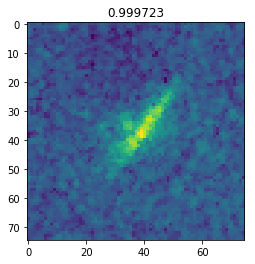

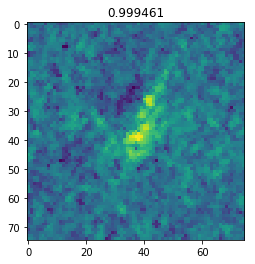

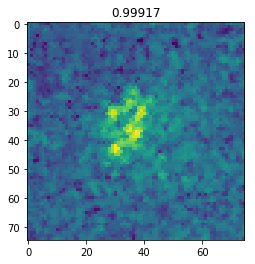

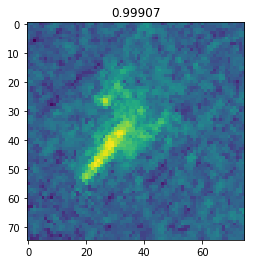

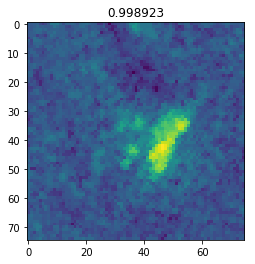

In [101]:
reload(utils)
utils.true_positive(vaild_df)

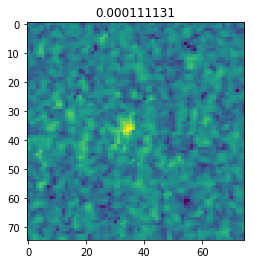

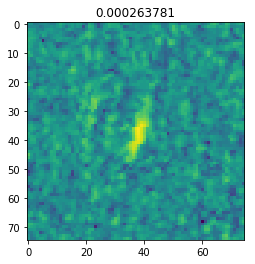

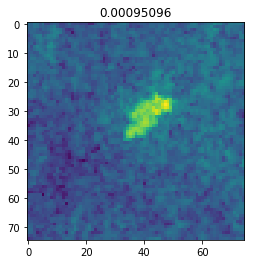

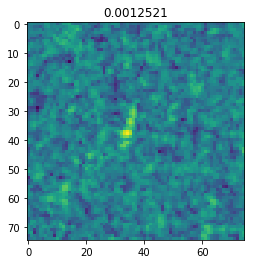

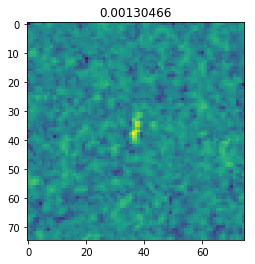

In [102]:
reload(utils)
utils.true_negetive(vaild_df)

utils.py:267: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  valid_negetive.sort_values('prediction',ascending=False,inplace=True)


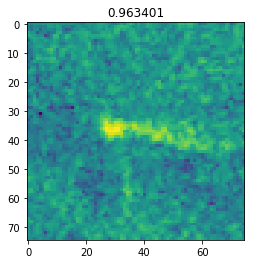

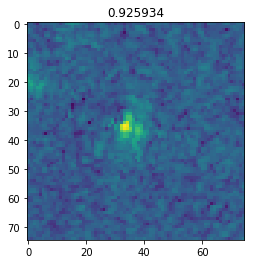

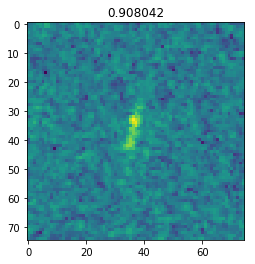

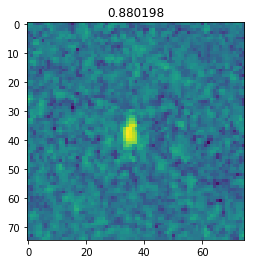

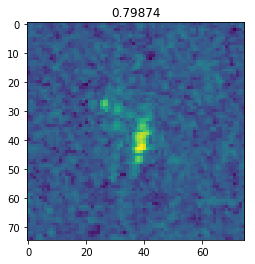

In [103]:
reload(utils)
utils.false_positive(vaild_df)

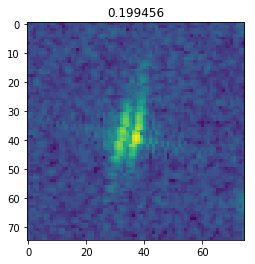

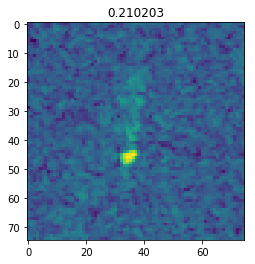

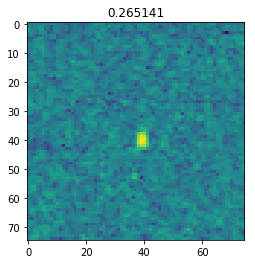

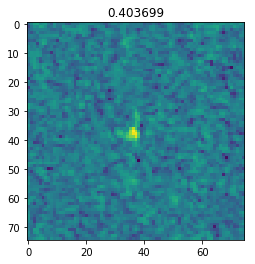

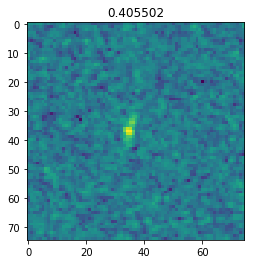

In [104]:
reload(utils)
utils.false_negative(vaild_df)

In [105]:
prediction = model.predict([X_test, X_angle_test], verbose=1, batch_size=200)

8424/8424 [==============================] - 357s     

In [106]:
submission = pd.DataFrame({'id': test["id"], 'is_iceberg': prediction.reshape((prediction.shape[0]))})
submission.head(10)

,id,is_iceberg
0,5941774d,0.069945
1,4023181e,0.059332
2,b20200e4,0.003987
3,e7f018bb,0.998756
4,4371c8c3,0.038764
5,a8d9b1fd,0.102595
6,29e7727e,0.211499
7,92a51ffb,0.991519
8,c769ac97,0.038708
9,aee0547d,0.007592


In [107]:
submission.to_csv("/home/ubuntu/statoil/submission/black_box_10_learning.csv", index=False)

In [17]:
X_train_final.shape

(1204, 75, 75, 3)

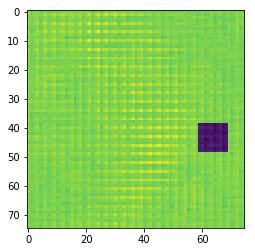

In [90]:
import matplotlib.pyplot as plt
plt.imshow((X_train_final[20 +3*602]).reshape(3,75,75)[1])
plt.show()

In [30]:
np.min(X_train_final[56 +1*602])

-36.611717

In [33]:
len(X_train)

602